# Imports

In [1058]:
import random
import math
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import special

import torch 
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torchsummary import summary

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cuda') 
print('device : ', device)
print('num gpu : ', torch.cuda.device_count())

device :  cuda
num gpu :  4


In [3]:
# torch.manual_seed(1234)
# np.random.seed(1234)
# random.seed(1234)

# Generate Data

In [23]:
class StepDataset(data.Dataset):
    
    def __init__(self, upper, lower, length, error_range):
        self.upper = upper
        self.lower = lower
        self.length = length
        self.error_range = error_range
        
        self.input = np.array([(self.upper - self.lower) * np. random.rand() + self.lower for i in range(self.length)]).reshape(-1,1).astype(np.float32)
        self.noise = np.array([2 * self.error_range * np. random.rand() - self.error_range for i in range(self.length)]).reshape(-1,1).astype(np.float32)
        self.output = (1 * (self.input > 0) + self.noise).astype(np.float32)

    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        x = self.input[index]
        y = self.output[index]
        
        return x, y

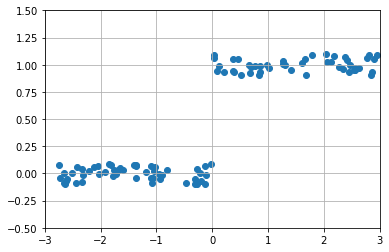

In [25]:
sample_dataset = StepDataset(3,-3,100,0.1)
sample_dataloader = torch.utils.data.DataLoader(sample_dataset,batch_size=100,shuffle=True)

sample_dataloader = iter(sample_dataloader)
x, y = next(sample_dataloader)


plt.scatter(x, y)
plt.xlim(-3, 3)
plt.ylim(-0.5, 1.5)
plt.grid()
plt.show()

# Basic Regression

## Modeling

In [123]:
class BasicRegressor(nn.Module):
    
    def __init__(self):
        super(BasicRegressor, self).__init__()
        self.layer1 = nn.Linear(1, 200)
        self.layer2 = nn.Linear(200, 200)
        self.last = nn.Linear(200, 1)
        self.dropout = nn.Dropout(p=0.01)
        
    def forward(self, x):
        out = self.layer1(x)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.layer2(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.last(out)
        
        return out

In [124]:
net = BasicRegressor().to(device)
print(net)
summary(net,(1,))

BasicRegressor(
  (layer1): Linear(in_features=1, out_features=200, bias=True)
  (layer2): Linear(in_features=200, out_features=200, bias=True)
  (last): Linear(in_features=200, out_features=1, bias=True)
  (dropout): Dropout(p=0.01, inplace=False)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]             400
           Dropout-2                  [-1, 200]               0
            Linear-3                  [-1, 200]          40,200
           Dropout-4                  [-1, 200]               0
            Linear-5                    [-1, 1]             201
Total params: 40,801
Trainable params: 40,801
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.16
Estimated Total Size (MB): 0.16
--------------------------------------------------

In [668]:
net = BasicRegressor()
net(torch.tensor([[0.]]))

tensor([[-0.0963]], grad_fn=<AddmmBackward>)

## Train

In [125]:
def train(model, dataloader, num_epochs):   
    model = nn.DataParallel(model)
    model.to(device)
    model.train()
    
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.MSELoss()
    
    for epoch in range(num_epochs):      
        t_epoch_start = time.time()
        epoch_loss = 0.0
        
        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')
        
        for data in dataloader:       
            batch_size = len(data[0])
            x = data[0].to(device)
            y = data[1].to(device)
            out = model(x)
            
            loss = criterion(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Loss:{:.4f} '.format(epoch, epoch_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        
    return model

In [126]:
dataset = StepDataset(3,-3,100,0.1)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=16,shuffle=True)

model = BasicRegressor().to(device)

model = train(model, dataloader, 100)

-------------
Epoch 1/100
-------------
-------------
epoch 0 || Loss:0.5503 
timer:  0.1091 sec.
-------------
Epoch 2/100
-------------
-------------
epoch 1 || Loss:0.1114 
timer:  0.0609 sec.
-------------
Epoch 3/100
-------------
-------------
epoch 2 || Loss:0.1206 
timer:  0.0592 sec.
-------------
Epoch 4/100
-------------
-------------
epoch 3 || Loss:0.0680 
timer:  0.0624 sec.
-------------
Epoch 5/100
-------------
-------------
epoch 4 || Loss:0.0569 
timer:  0.1109 sec.
-------------
Epoch 6/100
-------------
-------------
epoch 5 || Loss:0.0413 
timer:  0.0440 sec.
-------------
Epoch 7/100
-------------
-------------
epoch 6 || Loss:0.0362 
timer:  0.0560 sec.
-------------
Epoch 8/100
-------------
-------------
epoch 7 || Loss:0.0272 
timer:  0.0529 sec.
-------------
Epoch 9/100
-------------
-------------
epoch 8 || Loss:0.0246 
timer:  0.0414 sec.
-------------
Epoch 10/100
-------------
-------------
epoch 9 || Loss:0.0438 
timer:  0.0458 sec.
-------------
Epoch

-------------
epoch 83 || Loss:0.0277 
timer:  0.0441 sec.
-------------
Epoch 85/100
-------------
-------------
epoch 84 || Loss:0.0170 
timer:  0.0645 sec.
-------------
Epoch 86/100
-------------
-------------
epoch 85 || Loss:0.0166 
timer:  0.0624 sec.
-------------
Epoch 87/100
-------------
-------------
epoch 86 || Loss:0.0215 
timer:  0.0901 sec.
-------------
Epoch 88/100
-------------
-------------
epoch 87 || Loss:0.0157 
timer:  0.0856 sec.
-------------
Epoch 89/100
-------------
-------------
epoch 88 || Loss:0.0126 
timer:  0.0535 sec.
-------------
Epoch 90/100
-------------
-------------
epoch 89 || Loss:0.0154 
timer:  0.0680 sec.
-------------
Epoch 91/100
-------------
-------------
epoch 90 || Loss:0.0131 
timer:  0.0680 sec.
-------------
Epoch 92/100
-------------
-------------
epoch 91 || Loss:0.0160 
timer:  0.0911 sec.
-------------
Epoch 93/100
-------------
-------------
epoch 92 || Loss:0.0176 
timer:  0.0795 sec.
-------------
Epoch 94/100
-------------


## Validation

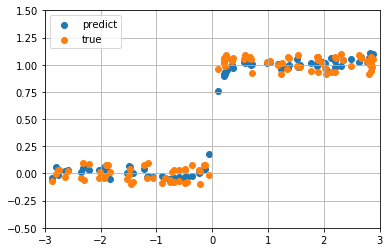

In [132]:
val_dataset = StepDataset(3,-3,100,0.1)
val_dataloader = iter(torch.utils.data.DataLoader(val_dataset,batch_size=100,shuffle=True))
val_data = next(val_dataloader)
val_x = val_data[0]
val_y = val_data[1]
pred_y = model(val_x).detach().cpu()


fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(val_x, pred_y, label="predict")
ax.scatter(val_x, val_y, label="true")
ax.grid()
ax.legend(loc='upper left')
plt.xlim(-3, 3)
plt.ylim(-0.5, 1.5)
fig.show()

# Stochastic Reression

## Modified ReLU

In [1267]:
def ReLUGauss(mu_in, var_in, epsilon=1.0e-6, cut_sd=4.0):
    mu_out = torch.zeros(mu_in.shape[0], mu_in.shape[1])
    var_out = torch.zeros(var_in.shape[0], var_in.shape[1])
    mu = mu_in
    var = var_in
    sigma = torch.sqrt(var)

    if (var < 0).any().item(): raise Exception(f"ERROR in ReLUGauss: 'var_in' should be all positive value, but it has negative value.")
    idx_SmallSigma = (sigma < epsilon)
#     if sigma < epsilon: 
#         mu_out[i], var_out[i] =  max(0., mu), 0.
#         continue
    #Approximation to speedup for abs(mu)>cut_sd*sigma.
    if cut_sd != None:
        idx_LargeMu = (mu > cut_sd*sigma)
        idx_SmallMU = (mu < -cut_sd*sigma)
#     if cut_sd != None and mu > cut_sd*sigma: 
#         mu_out[i], var_out[i] = mu, var
#         continue
#     if cut_sd != None and mu < -cut_sd*sigma:  
#         mu_out[i], var_out[i] = 0., 0.
#         continue

    sqrt2 = math.sqrt(2.0)
    sqrt2pi = math.sqrt(2.0*math.pi)
    z = mu / (sqrt2*sigma)
    E = torch.erf(z)
    X = torch.exp(-z*z)
    mu_out = sigma/sqrt2pi*X + mu/2.0*(1.0+E)
    var_out = (1.0+E)/4.0*(mu*mu*(1.0-E)+2.0*var) - sigma*X/sqrt2pi*(sigma*X/sqrt2pi+mu*E)
    
    idx_SmallVarOut = (var_out<0.0)*(var_out>-epsilon)
    isError = ((var_out<0.0)*(var_out<=-epsilon)).any().item()
    if isError:
        msg= f'ERROR in ReLUGauss: (mu: {mu}\n, sigma: {sigma}\n, mu_out: {mu_out}\n, var_out: {var_out}\n)'
        print(msg)
        raise Exception(msg)
    
#     if var_out[i]<0.0:
#         if var_out[i]>-epsilon:  
#             var_out[i] = 0.
#             continue
#         else:
#             msg= 'ERROR in ReLUGauss: %f, %f, %f, %f'%(mu, sigma, mu_out[i], var_out[i])
#             print(msg)
#             raise Exception(msg)

    mu_out = mu_out*~idx_SmallSigma + idx_SmallSigma*torch.relu(mu)
    var_out *= ~idx_SmallSigma
    if cut_sd != None:
        mu_out = mu_out*~(idx_LargeMu*~idx_SmallSigma) + (idx_LargeMu*~idx_SmallSigma)*mu
        var_out = var_out*~(idx_LargeMu*~idx_SmallSigma) + (idx_LargeMu*~idx_SmallSigma)*var
        mu_out = mu_out*~(idx_SmallMU*~np.logical_or(idx_LargeMu,idx_SmallSigma).type(torch.bool))
        var_out = var_out*~(idx_SmallMU*~np.logical_or(idx_LargeMu,idx_SmallSigma).type(torch.bool))
        var_out = var_out*~(idx_SmallVarOut*~np.logical_or(np.logical_or(idx_LargeMu,idx_SmallSigma).type(torch.bool),idx_SmallMU).type(torch.bool))
    else:
        var_out = var_out*~(idx_SmallVarOut*~idx_SmallSigma)
            
    var_out = torch.diag_embed(var_out)
    return mu_out, var_out

/home/yashima/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  if sys.path[0] == '':


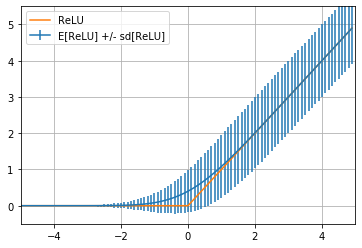

In [1274]:
length = 100
start = -5
end = 5
waith = end - start
x = torch.arange(start, end, waith/length).view(-1, 1)
in_var = torch.ones(length, 1)
y, out_var = ReLUGauss(x, in_var)
out_var = out_var.reshape(-1, 1)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.errorbar(x, y, torch.sqrt(out_var), label="E[ReLU] +/- sd[ReLU]")
ax.plot(x, torch.relu(x), label="ReLU")
ax.grid()
ax.legend(loc='upper left')
plt.xlim(start, end)
plt.ylim(-0.5, end+0.5)
fig.show()

## Custom DropOut

In [1275]:
class CustomDropout(nn.Module):
    
    __constants__ = ['p', 'inplace']

    def __init__(self, p=0.5, inplace=False):
        super(CustomDropout, self).__init__()
        if p < 0 or p > 1:
            raise ValueError("dropout probability has to be between 0 and 1, "
                             "but got {}".format(p))
        self.p = p
        self.inplace = inplace
    
    def forward(self, input):
        mu_in = input[0]
        var_in = input[1]
        flag = F.dropout(torch.ones(mu_in.shape[0], mu_in.shape[1]), self.p, self.training, self.inplace)
        mu_out = mu_in*flag
        var_out = var_in*(torch.diag_embed(flag))
        
        return mu_out, var_out
    
    def extra_repr(self):
        return 'p={}, inplace={}'.format(self.p, self.inplace)

## Modeling

In [1276]:
def ModifyInput(input):
    if input.dim() == 2:
        mu = input[:, 0].unsqueeze(-1)
        var = input[:, 1].unsqueeze(-1).unsqueeze(-1)
    else:
        raise Exception("Input shape should be (BATCH x 2).")
    return mu, var

def ModifyOutput(input):
    mu = input[0]
    var = input[1]
    out = torch.cat([mu, var], dim=1)
        
    return out


class StochasticLinear(nn.Module):
    
    def __init__(self, in_features, out_features):
        super(StochasticLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias = nn.Parameter(torch.Tensor(out_features))
        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound)
        
    def forward(self, input):
        mu_in = input[0]
        var_in = input[1]
        mu_out = mu_in @ self.weight.T + self.bias
        var_out = torch.diagonal(self.weight @ var_in @ self.weight.T, dim1=-2, dim2=-1)
                
        return mu_out, var_out
    
    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias
        )
    
    
class StochasticReLU(nn.Module):
    def __init__(self, inplace=False):
        super(StochasticReLU, self).__init__()
        self.inplace = inplace
        
    def forward(self, input):
        mu_in = input[0]
        var_in = input[1]
        mu_out, var_out = ReLUGauss(mu_in, var_in)
        return mu_out, var_out
        
    def extra_repr(self):
        inplace_str = 'inplace=True' if self.inplace else ''
        return inplace_str

In [1277]:
class StochasticRegressor(nn.Module):
    
    def __init__(self):
        super(StochasticRegressor, self).__init__()
        self.layer1 = StochasticLinear(1, 200)
        self.layer2 = StochasticLinear(200, 200)
        self.last = StochasticLinear(200, 1)
        self.dropout = CustomDropout(p=0.01)
        
    def forward(self, x):
        out = ModifyInput(x)
        out = self.layer1(out)
        out = StochasticReLU()(out)
        out = self.dropout(out)
        out = self.layer2(out)
        out = StochasticReLU()(out)
        out = self.dropout(out)
        out = self.last(out)
        out = ModifyOutput(out)
        
        return out

In [1278]:
input = torch.tensor([[1., 1.],[1., 1.],[1., 1.]])
model = StochasticRegressor()
model(input)

tensor([[0.2062, 0.0071],
        [0.2520, 0.0075],
        [0.2385, 0.0072]], grad_fn=<CatBackward>)